In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

import os, colorsys
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from keras.utils import multi_gpu_model
from PIL import Image, ImageFont, ImageDraw
from timeit import default_timer as timer

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image

In [3]:
class YOLO(object):
    
    _defaults = {
        "model_path": 'yolov3.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'classes.txt',
        "score": 0.3,
        "iou": 0.45,
        "model_image_size": (608, 608),
        "gpu_num": 1,
    }
    
    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"
        
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        self.__dict__.update(kwargs)
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()
        
    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            # 1行を文字列として1行毎に読み込む(改行文字も含む)
            anchors = f.readline()
        # floatで改行文字消去
        anchors = [float(x) for x in anchors.split(',')]
        # 2列の２次元配列に変換
        return np.array(anchors).reshape(-1, 2)
    
    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        # h5ファイル以外はAssertion Error
        # assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        # num_anchors==6ならばTrue
        is_tiny_version = num_anchors==6 # default setting
        try:
            # 以降学習しない OR モデル保存時にinclude_optimizer=False
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        #print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            # multi_gpu_model：複数GPUによる並列バッチ処理
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(
            self.yolo_model.output,
            self.anchors,
            len(self.class_names),
            self.input_image_shape,
            score_threshold=self.score,
            iou_threshold=self.iou
        )
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        # 画像をRGBに変換（追記）
        image=image.convert('RGB')

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            # アスペクト比を変えずに余白を使って画像をmodel_image_sizeにリサイズ
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)

        # 画像を配列に変換
        image_data = np.array(boxed_image, dtype='float32')
        #print(image_data.shape)

        # 正規化
        image_data /= 255

        # 軸を指定して次元追加
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        # TensorFlow
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 400

        detect_dict=[]
        for i, c in enumerate(out_classes):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            #label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            #label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            #print(label, (left, top), (right, bottom))

#             if top - label_size[1] >= 0:
#                 text_origin = np.array([left, top - label_size[1]])
#             else:
#                 text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    #outline=self.colors[c]
                    outline=(255, 255, 255)
                )
#             draw.rectangle(
#                 [tuple(text_origin), tuple(text_origin + label_size)],
#                 fill=self.colors[c])
            #draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

            detect_dict.append({
                #'label': label,
                #'class': predicted_class,
                'score': score,
                'left': left,
                'top': top,
                'right': right,
                'bottom': bottom
            })

        end = timer()
        #print(round(end - start, 2),"s")

        return image, detect_dict

    def close_session(self):
        self.sess.close()

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read()
        image = Image.fromarray(frame)
        image, detect_dict = yolo.detect_image(image)
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        if isOutput:
            out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    yolo.close_session()

In [4]:
# 必要な変数の定義
classes_gender = ["Male", "Female"]
classes_race = ["White", "Black", "Asian", "Indian", "Others"]

input_size = 200

In [5]:
%%time
yolo = YOLO()

CPU times: user 33.2 s, sys: 1.37 s, total: 34.6 s
Wall time: 34.2 s


In [6]:
%%time
model_gender = load_model('../data/model/sex_model_without_opt.hdf5', compile=False)
model_race = load_model('../data/model/race_model_without_opt.hdf5', compile=False)
model_age = load_model('../data/model/age_model_without_opt.hdf5', compile=False)

CPU times: user 1min 2s, sys: 751 ms, total: 1min 3s
Wall time: 1min 2s


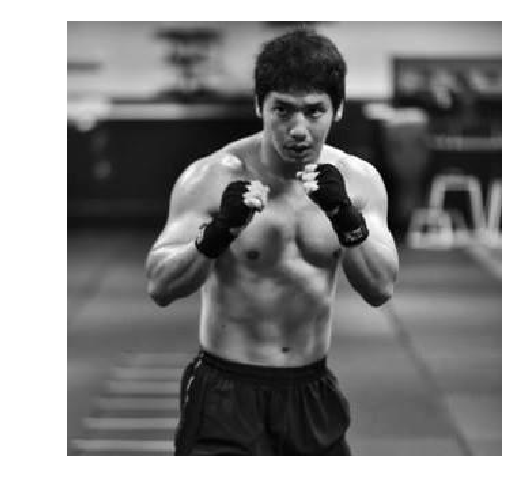

In [8]:
# 画像をロード
# テスト画像
# taylor_swift.jpg, masako_wakamiya.jpg, kids2_resized.jpg, indian_family.jpg
image = Image.open("test_imgs/masao_taketani.jpg")
plt.imshow(np.array(image))
plt.axis("off")
plt.show()

Found 1 boxes for img


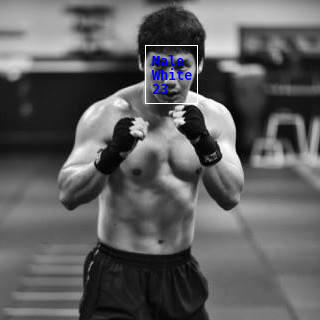

In [9]:
r_image, r_detect_dict = yolo.detect_image(image)

input_data = []
for i in range(len(r_detect_dict)):
    left = r_detect_dict[i]["left"]
    top = r_detect_dict[i]["top"]
    right = r_detect_dict[i]["right"]
    bottom = r_detect_dict[i]["bottom"]
    
    cropped_img = image.crop((left, top, right, bottom))
    resized_img = cropped_img.resize((input_size, input_size))
    
    np_arr_resized_img = np.asarray(resized_img)
    input_data.append(np_arr_resized_img)
    
np_arr_input_data = np.array(input_data)
np_arr_input_data = np_arr_input_data.astype('float32')
np_arr_input_data /= 255

pred_gender = np.argmax(model_gender.predict(np_arr_input_data), axis=1)
#pred_probs_gender = np.max(model_gender.predict(np_arr_input_data), axis=1)

pred_race = np.argmax(model_race.predict(np_arr_input_data), axis=1)
#pred_probs_race = np.max(model_race.predict(np_arr_input_data), axis=1)

pred_probs_age = model_age.predict(np_arr_input_data)

max_age = 116
processed_age = pred_probs_age * max_age
processed_age

size = np.floor(3e-2 * r_image.size[1] + 5).astype('int32')
draw = ImageDraw.Draw(r_image)
font = ImageFont.truetype(
    font='font/FiraMono-Medium.otf',
    size=size
)

for i in range(len(r_detect_dict)):
    score = r_detect_dict[i]["score"]
    left = r_detect_dict[i]["left"]
    top = r_detect_dict[i]["top"]
    gender = classes_gender[pred_gender[i]]
    #gender_score = pred_probs_gender[i]
    race = classes_race[pred_race[i]]
    #race_score = pred_probs_race[i]
    age = round(processed_age[i][0])
    
    draw.text((left + size * 0.5, top + size * 0.5), gender, fill=(0, 0, 255), font=font)
    draw.text((left + size * 0.5, top + size * 1.5), race, fill=(0, 0, 255), font=font)
    draw.text((left + size * 0.5, top + size * 2.5), str(int(age)), fill=(0, 0, 255), font=font)
    
r_image